In [2]:
""" sheet1_implementation.py

PUT YOUR NAME HERE:
Boris Bubla
Leonard Paeleke


Write the functions
- pca
- gammaidx
- lle
Write your implementations in the given functions stubs!


(c) Daniel Bartz, TU Berlin, 2013
"""


' sheet1_implementation.py\n\nPUT YOUR NAME HERE:\nBoris Bubla\nLeonard Paeleke\n\n\nWrite the functions\n- pca\n- gammaidx\n- lle\nWrite your implementations in the given functions stubs!\n\n\n(c) Daniel Bartz, TU Berlin, 2013\n'

In [3]:
import os
import numpy as np
import scipy.linalg as la
import scipy.spatial as sp
import matplotlib.pyplot as plt
from scipy.linalg import expm
import matplotlib.gridspec as gridspec
import scipy.io as sio

In [4]:
class PCA():
    """
        Definition of PCA Class
        Algorithms in guide.pdf used, pg 15-17
    """
    def __init__(self, Xtrain):
        """
            Compute Principal Components
        """
        # 1. centre data
        self.Xmean = np.mean(Xtrain, axis = 0)
        self.C = Xtrain - self.Xmean
        # 2. generate covariance marix
        self.C = np.cov(self.C, rowvar=False)
        # 3. calculate eigenvalues and eigenvectors
        self.D, self.U = np.linalg.eigh(self.C)
        
        self.idx = np.argsort(self.D)[::-1]
        # Sort the eigenvalue from high to low
        self.D = self.D[self.idx]
        # sort eigenvectors according to same index
        self.U = self.U[:,self.idx]
       
    def project(self, Xtest, m):
        """
            Projecting to the low-dimensional sub-space
        """
        # 1. centre data by mean of training
        Xtest = Xtest - self.Xmean
        # 2. project data to m principal components
        Z = self.U.T[range(m)].dot(Xtest.T).T    
        return Z
    
    def denoise(self, Xtest, m):
        """
            Reconstructing projected data points in the original space
        """
        # 1. projection to the low-dimencsional sub-space
        Z = self.project(Xtest, m)
        # 2. recontruction by m dimensions
        Y = Z.dot(self.U.T[range(m)])+self.Xmean
        return Y

In [43]:
def gammaidx(X, k):
    """
    Gamma identification for outlier detection by ranking
    """
    y = []
    # Calculate distance matrix
    # D = sp.distance_matrix(X, X) # forbidden
    
    #z = np.array([complex(c[0], c[1]) for c in X])
    #m, n = np.meshgrid(z, z) # just working for 2 D data?
    # get the distance via the norm
    #D = np.linalg.norm(m-n)
    
    #D = np.sqrt(np.sum((X[None, :] - X[:, None])**2, -1)) # ToDO Boris said it's not working 
    D = np.linalg.norm(X[None, :] - X[:, None], axis = 2)
    # Sort distance matrix
    kn = np.argsort(D,kind='mergesort')
    # identify k-nearest neighbours
    kn = kn[:,1:k+1]
    # sum over k-neaest neighbours and divide bei k
    y = np.sum(np.take_along_axis(D, kn, axis = 1),axis = 1)/k
    
    return y

In [68]:
y = gammaidx(X, k)

In [25]:
X = np.array([  [   0.5376671395461, -2.25884686100365, 0.318765239858981, -0.433592022305684, 3.57839693972576,
                            -1.34988694015652, 0.725404224946106, 0.714742903826096, -0.124144348216312, 1.40903448980048,
                            0.67149713360808, 0.717238651328838, 0.488893770311789, 0.726885133383238, 0.293871467096658,
                            0.888395631757642, -1.06887045816803, -2.9442841619949, 0.325190539456198, 1.37029854009523],
                        [   1.83388501459509, 0.862173320368121, -1.30768829630527, 0.34262446653865, 2.76943702988488,
                            3.03492346633185, -0.0630548731896562, -0.204966058299775, 1.48969760778546, 1.41719241342961,
                            -1.20748692268504, 1.63023528916473, 1.03469300991786, -0.303440924786016, -0.787282803758638,
                            -1.14707010696915, -0.809498694424876, 1.4383802928151, -0.754928319169703, -1.7115164188537]]).T
k = 3

In [25]:
correct_gamma = np.array([ 0.606051220224367, 1.61505686776722, 0.480161964450438, 1.18975154873627,
                                    2.93910520141032, 2.15531724762712, 0.393996268071324, 0.30516080506303,
                                    0.787481421847747, 0.895402545799062, 0.385599174039363, 0.544395897115756,
                                    0.73397995201338, 0.314642851266896, 0.376994725474732, 0.501091387197748,
                                    1.3579045507961, 1.96372676400505, 0.389228251829715, 0.910065898315003])

In [13]:
pos_label = 1
y_true = test1_y_true
y_pred = test1_y_pred

In [10]:
def auc(y_true,y_pred,plot=False):
    #1. FIND ROC CURVE POINTS & FPR/TPR
    pos_label=1
    y_true=(y_true==pos_label) #boolean vec of true labels

    #arrange predictions in descending order (indexes)
    descending_scores=np.argsort(y_pred,kind='mergesort')[::-1]
    #ascending_scores=np.argsort(y_pred,kind='mergesort')[::1]
    y_pred=y_pred[descending_scores]
    y_true=y_true[descending_scores]

    #determine distinct values to create an index of decreasing values
    #'predicted value in y_pred where lower values tend to correspond to label -1 and higher values to label +1'
    distinct_values_idx=np.where(np.diff(y_pred))[0]#length n-1 as calculating differences
    distinct_descending_scores_idx=np.r_[distinct_values_idx,y_true.size-1]# add last entry

    tps=np.cumsum(y_true)[distinct_descending_scores_idx]#cumulative sum of true positives using idx
    fps=1-tps+distinct_descending_scores_idx #same as cum sum of false positives

    #add 0,0 position for ROC curve
    tps=np.r_[0,tps]
    fps=np.r_[0,fps]

    #false/true positive rate
    fpr=fps/fps[-1] #rate=sum/max
    tpr=tps/tps[-1]
    
    #2.PLOT ROC CURVE POINTS
    if plot==True:
        plt.plot(fpr,tpr,label='Algorithm')
        plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),label='Random guesses')
        plt.ylabel('True Positive Rate (TPR)')
        plt.xlabel('False Positive Rate (FPR)')
        plt.title('ROC Curve')
        plt.legend()

    #3. CALCULATE AUC
    #reshape needed
    fpr=fpr.reshape(1,fpr.shape[0])
    tpr=tpr.reshape(1,tpr.shape[0])
    
    #assume positive area
    end=1
    #check if negative area (good discrimination, just switch labels)
    diff_fpr=np.diff(fpr)
    if np.all(diff_fpr<=0):
        end=-1
    #calculate area using trapezoidal approach
    area=end*np.trapz(tpr,fpr)

    return area

In [6]:
test1_y_true=np.array([-1, -1, -1, +1, +1])
test1_y_pred=np.array([0.3, 0.4, 0.5, 0.6, 0.7])#ans=1.0
test2_y_true=np.array([-1, -1, -1, +1, +1, +1])
test2_y_pred=np.array([0.3, 0.4, 0.6, 0.5, 0.7, 0.8])#ans=0.89
test3_y_true=np.array([+1, -1, -1, +1, +1, -1])
test3_y_pred=np.array([0.3, 0.4, 0.6, 0.5, 0.7, 0.8])#ans=1/3

array([1.])

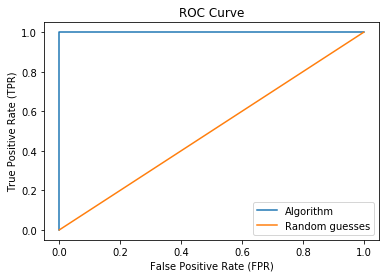

In [30]:
auc(test1_y_true,test1_y_pred,plot=True)

array([0.88888889])

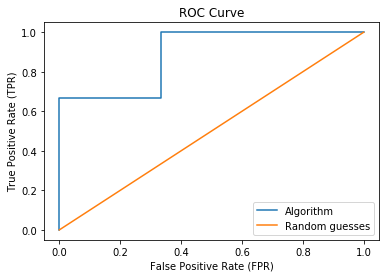

In [31]:
auc(test2_y_true,test2_y_pred,plot=True)

In [32]:
auc(test3_y_true,test3_y_pred,plot=False)

array([0.33333333])

In [56]:
def lle(X, m, tol, n_rule, k=None, epsilon=None):
    """
        Locally Linear Embedding
    """
    
    # compute neighborhoord by kNN or eps-bole rule
    
    # 1. calculate euclidean distance of data
    #D = np.sqrt(np.sum((X[None, :] - X[:, None])**2, -1))
    D = np.linalg.norm(X[None, :] - X[:, None], axis = 2)
    
    # 2. check for applied rule
    if n_rule == 'knn':
        # check if k is provided
        assert (k != None), """The parameter 'k' is required for the 'knn' rule"""
        # 3a. calculate k nearest neighbors
        # Sort distance matrix
        kn = np.argsort(D,kind='mergesort')
        # identify k-nearest neighbors
        kn = kn[:,1:k+1]
        
    elif n_rule == 'eps-ball':
        # check if epsilon is provided
        assert (epsilon != None), """The parameter 'epsilon' is required for the 'eps-ball' rule"""
        # 3b. compare distance by epsilon
        # tupel (1. element, 2. element)
        idx = np.argwhere(D<epsilon)
        # row wise all points in the neighborhood
        kn = [idx[:,1][idx[:,0]==i] for i in np.unique(idx[:,0])]
    else:
        print("""The following rule {} is not known. Please use either 'knn' or 'eps-ball'.""".format(n_rule))
    
    # 4. calculate reconstruction weights 
    # intialize weight matrix
    W = np.zeros((len(X),len(X)))
    # calculate weights for every point
    for i in range(len(X)):
        # calculate covariance matrix
        C = np.cov(X[kn[i]])
        # solve for weights 
        I = np.eye(len(X[kn[i]]))
        weights = np.linalg.inv(C-tol*I).dot(np.ones(len(X[kn[i]])).reshape(len(X[kn[i]]),1))
        # normalize weights
        weights = (1/(weights.T.dot(np.ones(len(X[kn[i]])).reshape(len(X[kn[i]]),1)))*weights).reshape(len(X[kn[i]]))
        W[i,kn[i]] = weights
    
    # 5. calculate cost matrix
    I = np.eye(len(X))
    M = (I - W).T@(I-W)
    
    # 6. Obtain eigenvalues and eigenvector of M
    eigen_values, eigen_vector = np.linalg.eig(M)
    # sort eigenvalues in ascending order
    eigen_kn = np.argsort(abs(eigen_values),kind='mergesort').reshape(len(X),1)
    # sort eigenvectors by eigenvalues, eigenvector along columns, first eigenvector -> [:,0]
    V = -1*np.take_along_axis(eigen_vector.T, eigen_kn, axis = 0).T # CAVEAT: mulitplying by -1 because numpy.eig routine delivers wrong sign
    
    # 7. embedded dimension 
    Y = V[:,1:m+1]
    return Y

In [680]:
V = lle(X,5,0.05,'eps-ball',epsilon = 3)

In [681]:
V.shape

(500, 5)

In [682]:
V

array([[ 1.28962417e-01,  7.28554888e-02,  2.00914471e-02,
         1.43531644e-01,  7.06207733e-02],
       [-9.81346956e-03,  3.37816024e-03, -6.73688337e-02,
         1.94501152e-02,  6.07737451e-03],
       [ 4.03745017e-02, -3.01612695e-02, -6.84006354e-02,
        -4.84089482e-03,  1.03704946e-02],
       ...,
       [ 1.33520601e-02, -9.17862374e-03,  7.01616962e-03,
        -4.22444836e-03, -5.98989146e-03],
       [-1.31070463e-02, -2.95608772e-02, -3.61561346e-02,
         1.54710138e-02, -6.53557598e-02],
       [ 4.95130484e-03,  1.30161773e-03, -3.43414478e-03,
        -2.40359193e-05, -1.48596022e-02]])

In [631]:
kn = np.argsort(abs(eigen_values),kind='mergesort').reshape(len(X),1)
# identify k-nearest neighbours
#kn = kn[:,1:k+1]
# sum over k-neaest neighbours and divide bei k
y = np.take_along_axis(eigen_vector.T, kn, axis = 0).T

In [32]:
# Test set for lle
def randrot(d):
    '''generate random orthogonal matrix'''
    M = 100. * (np.random.rand(d, d) - 0.5)
    M = 0.5 * (M - M.T);
    R = expm(M);
    return R

def test_lle():
    n = 500
    Xt = 10. * np.random.rand(n, 2);
    X = np.append(Xt, 0.5 * np.random.randn(n, 8), 1);

    # Rotate data randomly.
    X = np.dot(X, randrot(10).T)
    return X

In [ ]:
# ASSIGNMENT 5

In [5]:
# Load data
cwd = os.getcwd()
file_name = 'usps.mat'
path_to_data = cwd + '/data/'+file_name
assert os.path.exists(path_to_data), "The path to the data does not exist."

data = sio.loadmat(path_to_data)

data_labels = data['data_labels']
data_patterns = data['data_patterns']

In [6]:
# Plot function for 2 b
def plot_fun(pca):
    """
    Plot function for Assignment 5
    Arranges the prinicple components plots
    """
    # intialize figure environment
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(5, 3)
    
    # first plot: all principle components
    f_ax1 = fig.add_subplot(gs[:, 0])
    plt.bar(range(len(pca.D)),pca.D)
    plt.xticks(range(0, len(pca.D), 50), np.append(1,np.arange(50, len(pca.D), 50)))
    plt.title('all principle components')
    
    # second plot: first 25 principle components
    fig.add_subplot(gs[:, 1])
    plt.bar(range(25),pca.D[:25])
    plt.title('first 25 principle components')
    plt.xticks(range(0, 25, 6), range(1,26,6))


    # third plot: visualize first 5 principle components
    for i in range(5):
        f_ax3 = fig.add_subplot(gs[i, 2])
        if i == 0:
            f_ax3.set_title('first 5 components')
        plt.imshow(pca.U[i].reshape(16,16), cmap = 'gray')

    plt.show()

In [7]:
# perform pca
pca = PCA(data_patterns.T)

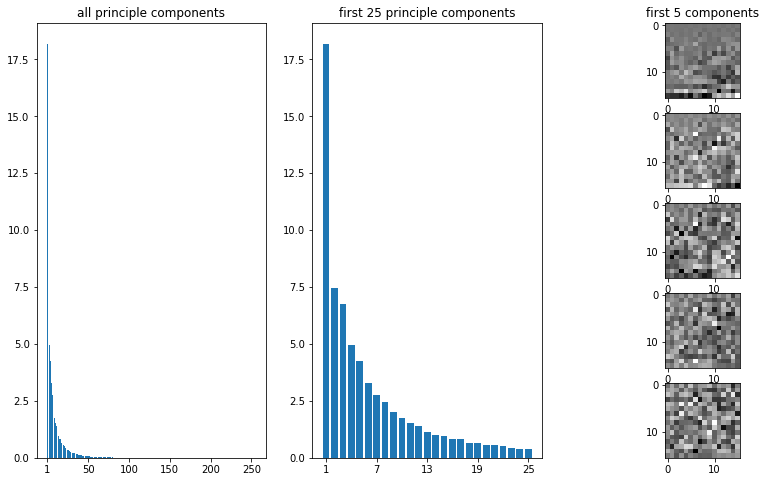

In [8]:
plot_fun(pca)

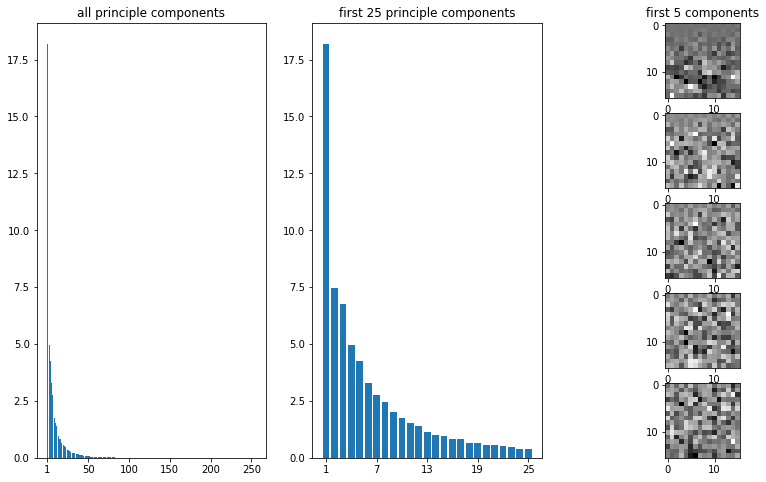

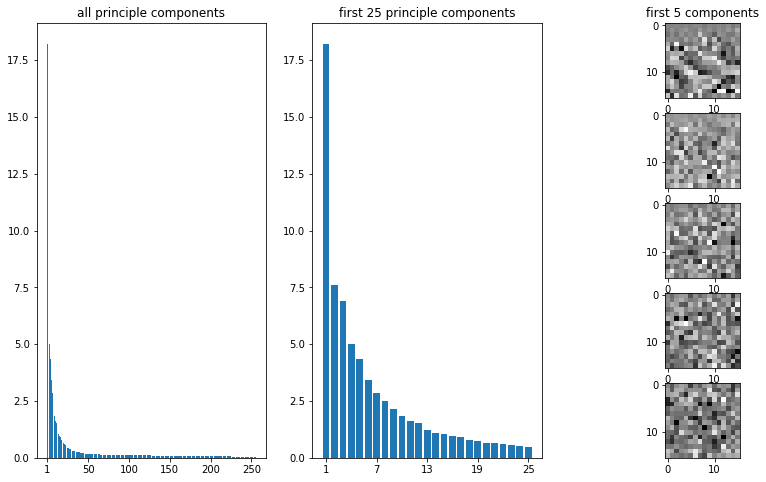

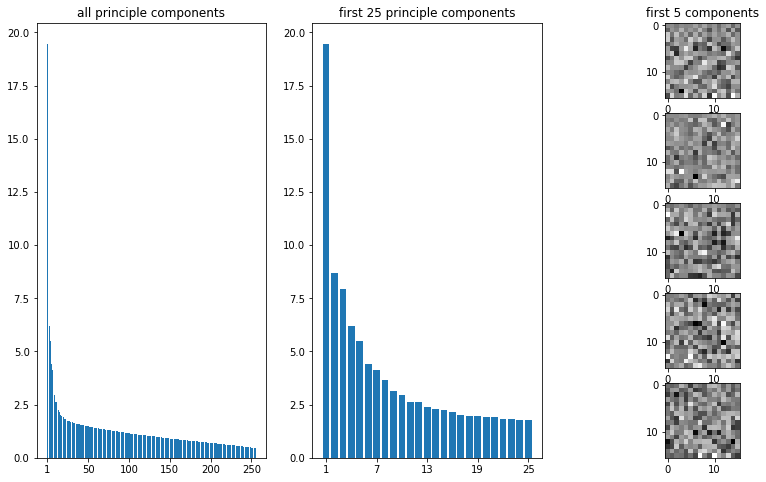

In [18]:
# Plot 3a).
# generate noisy data
sigmas = [0.05, 0.3, 1]
length, width= data_patterns.T.shape
counter = 1
#sigmas = [1]
for sigma in sigmas:
    
    data_patterns_noisy = np.copy(data_patterns.T) # prevent same disk space of variables
    # principle component evaluation
    if counter !=3:
        # noisy data
        length, width = data_patterns.T.shape
        data_patterns_noisy = sigma * np.random.randn(length, width) + data_patterns_noisy
    else:
        # outlier data
        pics = [0,1,2,13,34]
        length, width = data_patterns_noisy[[0,1,2,13,34]].shape
        # add gaussian noise to only 5 data points
        data_patterns_noisy[[0,1,2,13,34]] = sigma * np.random.randn(length, width) + data_patterns_noisy[[0,1,2,13,34]]
    
    pca_noise = PCA(data_patterns_noisy)
    plot_fun(pca_noise)
    
    # reconstruction by m principle components
    data_patterns_pjt = pca_noise.denoise(data_patterns_noisy,13)
    #img_num = 0
    #plt.figure(figsize=(14, 8))
    #plt.subplot(1,2,1)
    #plt.imshow(data_patterns_pjt[img_num].reshape(16,16))#,cmap = 'gray')
    #plt.subplot(1,2,2)
    #plt.imshow(data_patterns_noisy[img_num].reshape(16,16))#, cmap = 'gray')

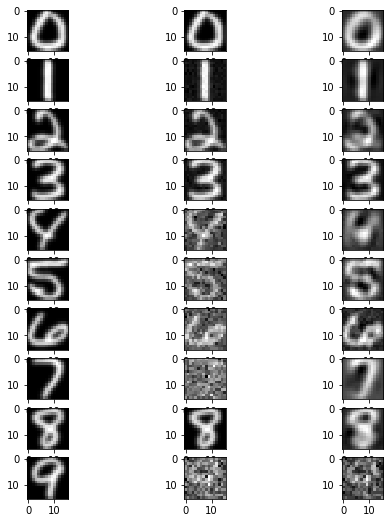

In [19]:
# 3b/c).
# generate noisy data
sigmas = [0, 0.05, 0.05, 0.05, 0.3, 0.3, 0.3, 1, 1, 1]
img_num = [5, 69, 68, 2, 13, 121, 1, 34, 70, 0] # 0 - 9
m = [7, 7, 25, 50, 7, 25, 50, 7, 25, 50]
length, width= data_patterns.T.shape

fig = plt.figure(figsize=(8, 9))
gs = fig.add_gridspec(10, 3)
for idx, sigma in enumerate(sigmas):
    
    data_patterns_noisy = np.copy(data_patterns.T) # prevent same disk space of variables
    # principle component evaluation
    if sigma !=1:
        # noisy data
        length, width = data_patterns.T.shape
        data_patterns_noisy = sigma * np.random.randn(length, width) + data_patterns_noisy
    else:
        # outlier data
        pics = [0,1,2,13,34]
        length, width = data_patterns_noisy[[0,1,2,13,34]].shape
        # add gaussian noise to only 5 data points
        data_patterns_noisy[[0,1,2,13,34]] = sigma * np.random.randn(length, width) + data_patterns_noisy[[0,1,2,13,34]]
    
    pca_noise = PCA(data_patterns_noisy)
    #plot_fun(pca_noise)
    
    # reconstruction by m principle components
    data_patterns_pjt = pca_noise.denoise(data_patterns_noisy,m[idx])
    #img_num = 0
    f_ax1 = fig.add_subplot(gs[idx, 0])
    plt.imshow(data_patterns.T[img_num[idx]].reshape(16,16), cmap = 'gray')
    f_ax1 = fig.add_subplot(gs[idx, 1])
    plt.imshow(data_patterns_noisy[img_num[idx]].reshape(16,16), cmap = 'gray')
    f_ax1 = fig.add_subplot(gs[idx, 2])
    plt.imshow(data_patterns_pjt[img_num[idx]].reshape(16,16),cmap = 'gray')

In [ ]:
#ASSIGNMENT 6

In [47]:
#using old gammaidx function since it's stable -- the norm version threw an error.
def gammaidx(X, k):
    """
    Gamma identification for outlier detection by ranking
    """
    y = []
    # Calculate distance matrix
    #D = sp.distance_matrix(X, X)
    D = np.linalg.norm(X[None, :] - X[:, None], axis = 2)
    # Sort distance matrix
    kn = np.argsort(D,kind='mergesort')
    # identify k-nearest neighbours
    kn = kn[:,1:k+1]
    # sum over k-neaest neighbours and divide bei k
    y = np.sum(np.take_along_axis(D, kn, axis = 1),axis = 1)/k
    
    return y

In [57]:
#load and unpack data
# Load data
cwd = os.getcwd()
file_name = 'banana.npz'
path_to_data = cwd + '/data/'+file_name
assert os.path.exists(path_to_data), "The path do the data does not exist."

data = np.load(path_to_data)
lst = data.files
for item in lst:
    print(item)
    print(data[item])

data
[[-3.0898387  -2.9808342  -2.8360574  ...  2.7103145   2.7544469
   2.8133603 ]
 [-0.83168647 -0.15957534 -0.17708113 ...  1.3465977   1.4719528
   1.3016674 ]]
label
[[-1. -1. -1. ...  1.  1.  1.]]


In [49]:
#data manipulation and preprocessing
outlier_rate=np.array([0.01,0.1,0.5,1])
pos_idx=np.argwhere(data['label']==1).T[1]#idx of pos class
n_outliers=np.round(outlier_rate*len(pos_idx))
pos_data=data['data'].T[pos_idx]
n_outliers=n_outliers.astype(int)

In [50]:
#This takes about 25min to run --- inefficient but gets the job done.
loops=50

results_3=np.empty((loops,len(n_outliers)))
results_10=np.empty((loops,len(n_outliers)))
results_mean=np.empty((loops,len(n_outliers)))

for i in range(loops):
    
    
    for j in n_outliers:
        
        #draw outliers from uniform box
        outliers=np.random.uniform(low=-4,high=4,size=(j,2))
        print(outliers[0][0])
        
        #reset data
        data_=data['data'].T
        labels_=data['label'].T
        #print(data_.shape)
        #print(labels_.shape)
        
        #add outliers to positive class
        data_=np.append(data_,outliers,axis=0)
        labels_=np.append(labels_,np.ones((j,1)),axis=0)
        
        #print(data_.shape)
        #print(labels_.shape)
        
        #compute gamma 3,10,mean
        gamma_3=gammaidx(data_,3)
        gamma_10=gammaidx(data_,10)
        #compute dist_to_mean
        diff=np.subtract(data_,np.mean(data_,axis=0))
        dist_to_mean=np.linalg.norm(diff,axis=1)
        
        #print("gamma_3",gamma_3)
        #print("gamma10",gamma_10)
        #print("dist_to_mean",dist_to_mean)
        
        #compute auc
        auc_3=auc(labels_,gamma_3)
        auc_10=auc(labels_,gamma_10)
        auc_mean=auc(labels_,dist_to_mean)
        
        #print("auc 3",auc_3)
        #print("auc 10",auc_10)
        #print("auc mean",auc_mean)
        
        #store results
        results_3[i][np.argwhere(n_outliers==j)]=auc_3[0]
        results_10[i][np.argwhere(n_outliers==j)]=auc_10[0]
        results_mean[i][np.argwhere(n_outliers==j)]=auc_mean[0]
        
        
        

3.7947791888712565
-2.162281770936456
-2.2463425323178177
-0.26339123255610986


In [51]:
#reset data
data_=data['data'].T
labels_=data['label'].T
        #print(data_.shape)
        #print(labels_.shape)
        
        #add outliers to positive class
data_=np.append(data_,outliers,axis=0)
labels_=np.append(labels_,np.ones((j,1)),axis=0)
        
        #print(data_.shape)
        #print(labels_.shape)
        
        #compute gamma 3,10,mean
gamma_3=gammaidx(data_,3)

In [52]:
gamma_3

array([0.06054104, 0.18980972, 0.12435898, ..., 0.18877843, 0.11976904,
       0.14781921])

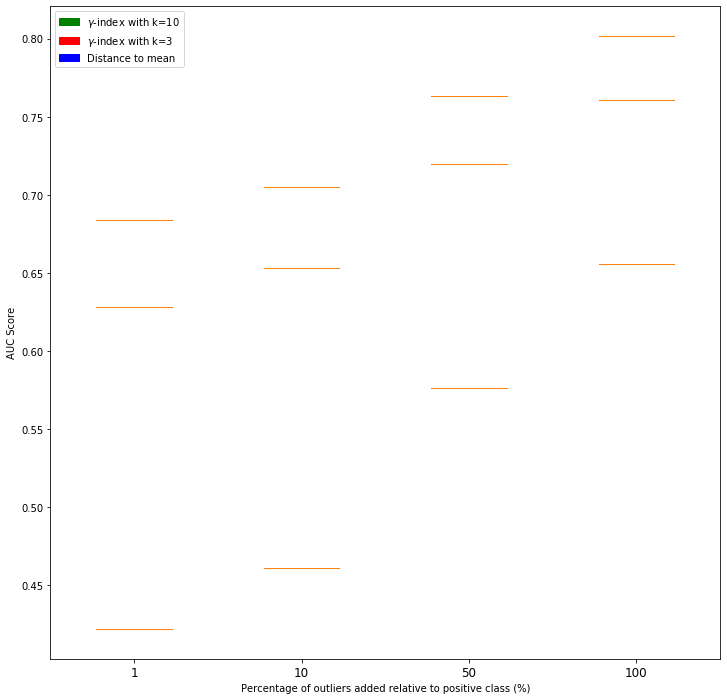

In [53]:
#plot the results
fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlabel('Percentage of outliers added relative to positive class (%)')
ax.set_ylabel('AUC Score')
bp1=ax.boxplot(results_10,patch_artist=True,boxprops=dict(facecolor='green', color='green'))
bp2=ax.boxplot(results_3,patch_artist=True,boxprops=dict(facecolor='red', color='red'))
bp3=ax.boxplot(results_mean,patch_artist=True,boxprops=dict(facecolor='blue', color='blue'))
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['1', '10', '50', '100'], fontsize=12)
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['$\gamma$-index with k=10', '$\gamma$-index with k=3','Distance to mean'], loc='upper left')


In [54]:
#exemplary run
n_outliers=np.array([1188])#50% contamination

#draw outliers from uniform box
outliers=np.random.uniform(low=-4,high=4,size=(n_outliers[0],2))
        
#pos data
pos=data['data'].T
        
#add outliers to positive class
data_=np.append(pos,outliers,axis=0)
        
#compute gamma 3,10,mean
gamma_3=gammaidx(data_,3)
gamma_10=gammaidx(data_,10)
#compute dist_to_mean
diff=np.subtract(data_,np.mean(data_,axis=0))
dist_to_mean=np.linalg.norm(diff,axis=1)

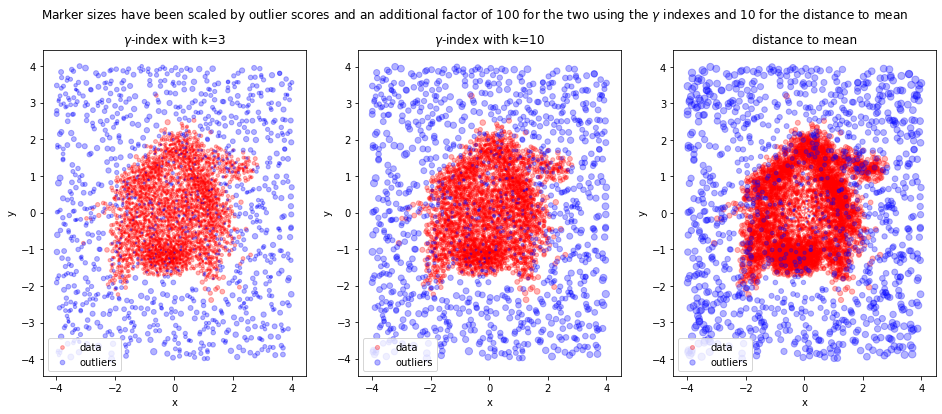

In [55]:
#exemplary plots
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16,6))
fig.suptitle('Marker sizes have been scaled by outlier scores and an additional factor of 100 for the two using the $\gamma$ indexes and 10 for the distance to mean', fontsize=12)

axes[0].scatter(x=pos.T[0],y=pos.T[1],s=gamma_3[:5300]*100,c='r',label='data',alpha=0.3,edgecolors=None,)
axes[0].scatter(x=outliers.T[0],y=outliers.T[1],s=gamma_3[5300:]*100,c='b',label='outliers',alpha=0.3,edgecolors=None)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('$\gamma$-index with k=3')
axes[0].legend()

axes[1].scatter(x=pos.T[0],y=pos.T[1],s=gamma_10[:5300]*100,c='r',label='data',alpha=0.3,edgecolors=None,)
axes[1].scatter(x=outliers.T[0],y=outliers.T[1],s=gamma_10[5300:]*100,c='b',label='outliers',alpha=0.3,edgecolors=None)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('$\gamma$-index with k=10')
axes[1].legend()

axes[2].scatter(x=pos.T[0],y=pos.T[1],s=dist_to_mean[:5300]*10,c='r',label='data',alpha=0.3,edgecolors=None,)
axes[2].scatter(x=outliers.T[0],y=outliers.T[1],s=dist_to_mean[5300:]*10,c='b',label='outliers',alpha=0.3,edgecolors=None)
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].set_title('distance to mean')
axes[2].legend()


In [58]:
# Assginment 8

In [800]:
def lle(X, m, tol, n_rule, k=None, epsilon=None):
    """
        Locally Linear Embedding
    """
    
    # compute neighborhoord by kNN or eps-bole rule
    
    # 1. calculate euclidean distance of data
    D = np.sqrt(np.sum((X[None, :] - X[:, None])**2, -1))
    
    # 2. check for applied rule
    if n_rule == 'knn':
        # check if k is provided
        assert (k != None), """The parameter 'k' is required for the 'knn' rule"""
        # 3a. calculate k nearest neighbors
        # Sort distance matrix
        kn = np.argsort(D,kind='mergesort')
        # identify k-nearest neighbors
        kn = kn[:,1:k+1]
        
    elif n_rule == 'eps-ball':
        # check if epsilon is provided
        assert (epsilon != None), """The parameter 'epsilon' is required for the 'eps-ball' rule"""
        # 3b. compare distance by epsilon
        # tupel (1. element, 2. element)
        #idx = np.argwhere(D<epsilon)
        # row wise all points in the neighborhood
        #kn = [idx[:,1][idx[:,0]==i] for i in np.unique(idx[:,0])]
        
        # 3b. compare distance by epsilon
        #boolean approach
        kn=D<epsilon
    else:
        print("""The following rule {} is not known. Please use either 'knn' or 'eps-ball'.""".format(n_rule))
    
    # 4. calculate reconstruction weights 
    # intialize weight matrix
    W = np.zeros((len(X),len(X)))
    # calculate weights for every point
    for i in range(len(X)):
        # calculate covariance matrix
        C = np.cov(X[i]-X[kn[i]])
        # solve for weights 
        I = np.eye(len(X[kn[i]]))
        weights = np.linalg.inv(C-tol*I).dot(np.ones(len(X[kn[i]])).reshape(len(X[kn[i]]),1))
        # normalize weights
        weights = (1/(weights.T.dot(np.ones(len(X[kn[i]])).reshape(len(X[kn[i]]),1)))*weights).reshape(len(X[kn[i]]))
        W[i,kn[i]] = weights
    
    # 5. calculate cost matrix
    I = np.eye(len(X))
    M = (I - W).T@(I-W)
    
    # 6. Obtain eigenvalues and eigenvector of M
    eigen_values, eigen_vector = np.linalg.eigh(M)
    # sort eigenvalues in ascending order
    eigen_kn = np.argsort(abs(eigen_values),kind='mergesort').reshape(len(X),1)
    # sort eigenvectors by eigenvalues, eigenvector along columns, first eigenvector -> [:,0]
    V = -1*np.take_along_axis(eigen_vector.T, eigen_kn, axis = 0) # CAVEAT: mulitplying by -1 because numpy.eig routine delivers wrong sign
    
    # 7. embedded dimension 
    Y = V[:,1:m+1]
    
    #8 Check connected graphs
    if (connected_components(V,directed=False)[0]!=1):
        raise ValueError('Graphs are not connected!')
        
    return Y

In [803]:
#FLATROLL
# load data 
cwd = os.getcwd()
file_name = 'flatroll_data.npz'
path_to_data = cwd + '/data/'+file_name
assert os.path.exists(path_to_data), "The path does not excist."
flatroll = np.load(path_to_data)

flatroll_data=flatroll['Xflat'].T
flatroll_ref=flatroll['true_embedding'].T

In [908]:
#plot function for assignmanet 8
def plot_8(flatroll_data, flatroll_ref,flatroll_lle,k):
    # normalize flatroll_ref -> values from 0 to 1
    color_code = ((flatroll_ref-min(flatroll_ref))/(max(flatroll_ref)-min(flatroll_ref))).reshape(len(flatroll_ref),)
    
    fig = plt.figure(figsize=(18,8))

    # `ax` is a 3D-aware axis instance because of the projection='3d' keyword argument to add_subplot
    ax = fig.add_subplot(1, 2, 1)
    #ax.scatter(x=flatroll_data.T[0],y=flatroll_data.T[1],s=3, c=color_code,cmap='hsv')
    plot_knn(flatroll_data, k)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    #ax.set_xticks([-1,-0.5,0,0.5,1])
    #ax.set_yticks([-1,-0.5,0,0.5,1])
    #ax.set_zticks([-1,-0.5,0,0.5,1])
    ax.set_title('Flatroll in 2D')

    ax = fig.add_subplot(1, 2, 2)
    y=np.zeros((len(flatroll_data),))
    ax.scatter(x=flatroll_ref.reshape(len(flatroll_ref),),y=flatroll_lle.T,s=3, c=color_code,cmap='hsv')

    ax.set_xlabel('flattroll_ref')
    ax.set_ylabel('X2')

    ax.set_title('Flatroll in 1D') #I think this should be a line. (correct)

In [833]:
#apply lle
#flatroll_lle=lle(flatroll_data,1,0.00001,'eps-ball',epsilon=1.7)#k=9 is best I found. epsilon didn't work so well here
flatroll_lle=lle(flatroll_data,1,0.00001,'knn',k = 7)

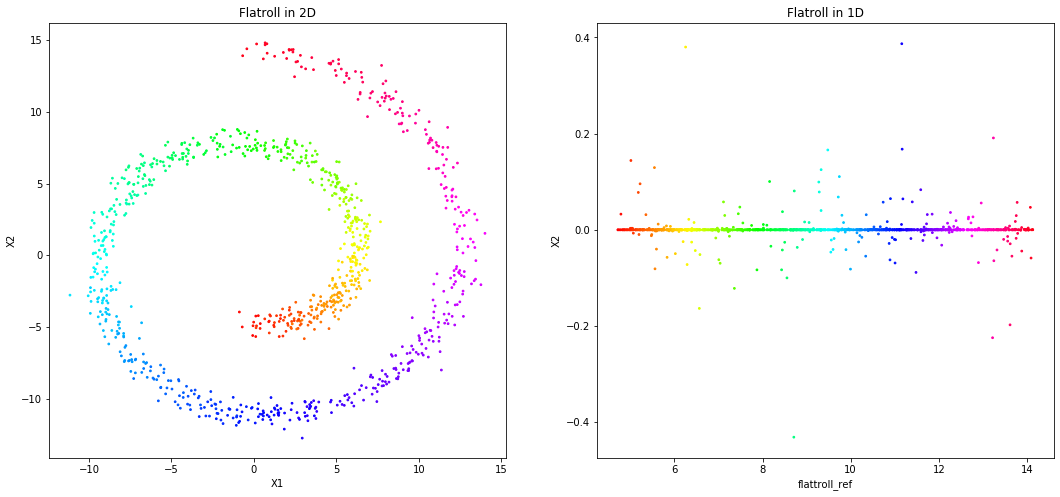

In [834]:
plot_8(flatroll_data, flatroll_ref, flatroll_lle)

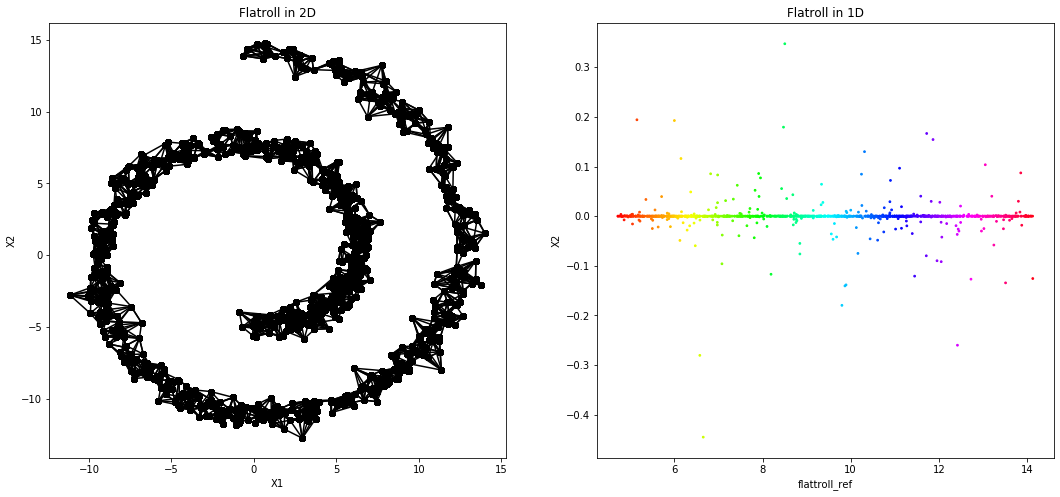

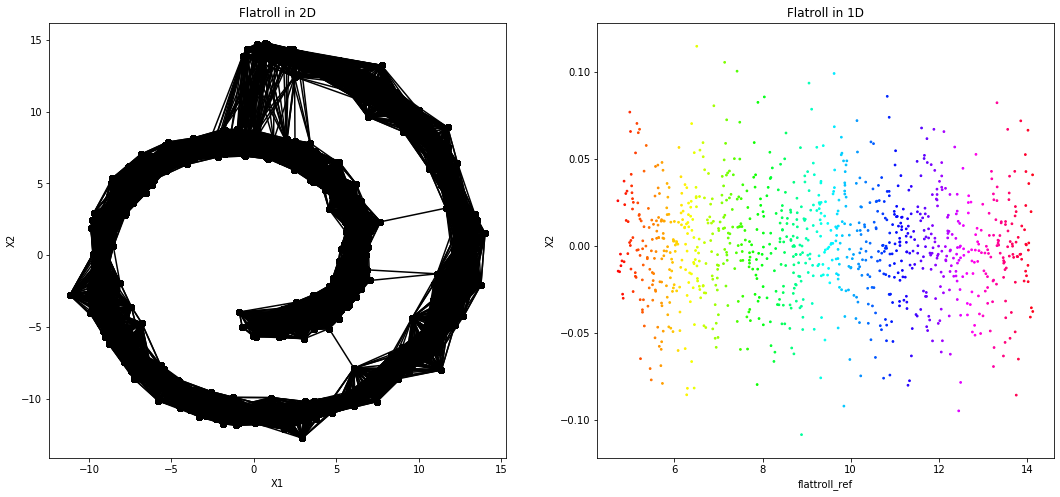

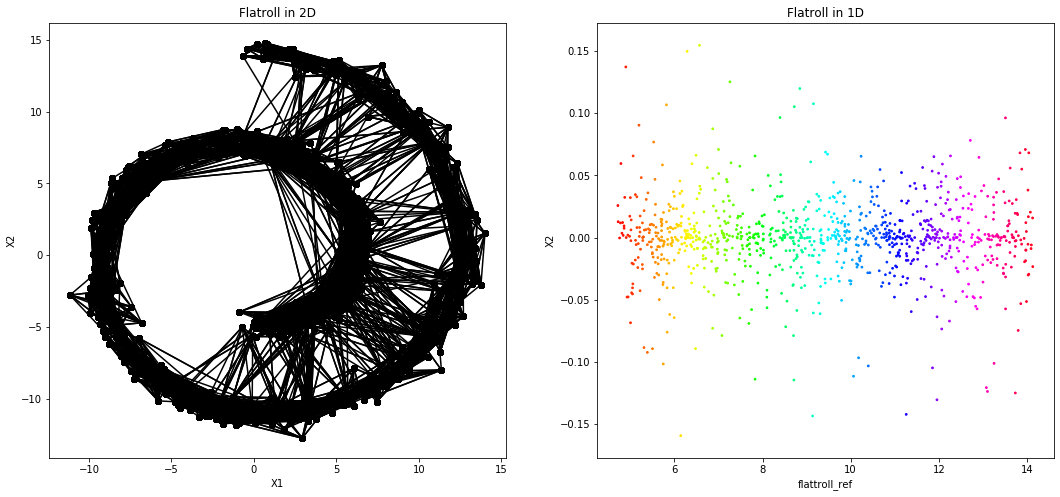

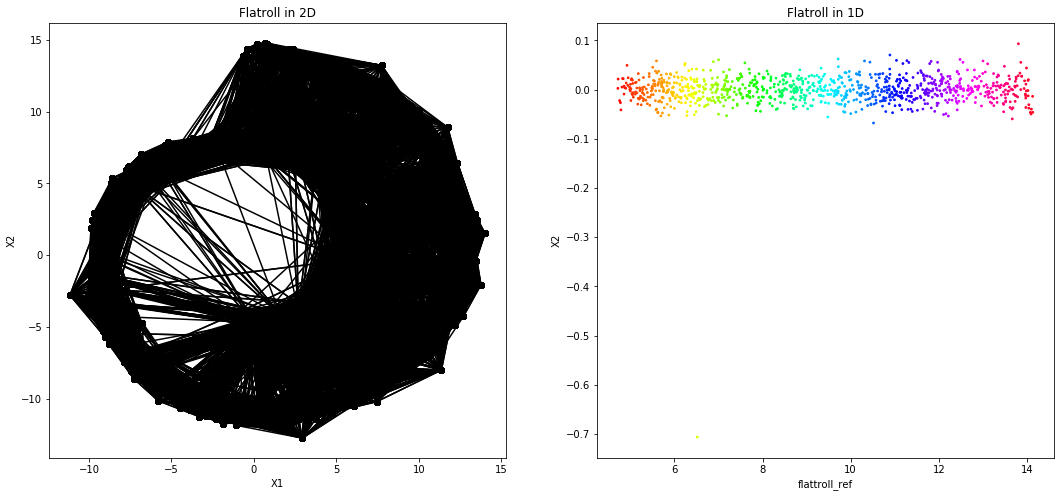

In [910]:
sigmas = [0.2, 0.2, 1.8, 1.8]
k = [9,50,9,50]
length, width = flatroll_data.shape

for idx, sigma in enumerate (sigmas):
    flatroll_data_noise =  sigma * np.random.randn(length, width) + flatroll_data
    flatroll_lle=lle(flatroll_data_noise,1,1e-6,'knn',k = k[idx])
    plot_8(flatroll_data_noise, flatroll_ref, flatroll_lle, k[idx])

In [873]:
from sklearn.neighbors import kneighbors_graph
kneighbors_graph(flatroll_data, 9, mode='connectivity', include_self=True)

ModuleNotFoundError: No module named 'sklearn'

In [883]:
D = np.sqrt(np.sum((flatroll_data[None, :] - flatroll_data[:, None])**2, -1))
kn = np.argsort(D,kind='mergesort')
k = 9
# identify k-nearest neighbors
kn = kn[:,:k+1]

In [905]:
def plot_knn(X, k):
    D = np.sqrt(np.sum((X[None, :] - X[:, None])**2, -1))
    kn = np.argsort(D,kind='mergesort')
    # identify k-nearest neighbors
    kn = kn[:,:k+1]
    length, width = kn.shape
    for i in range(length):
        for j in range(width-1):
            plt.plot(flatroll_data[kn[i][[0,j]]][:,0],flatroll_data[kn[i][[0,j]]][:,1], 'k-o')

In [892]:
flatroll_data[kn[0]][:,0]

array([12.13376467, 12.22699107, 12.00601693, 11.92831365, 12.15107142,
       12.68567008, 12.58393723, 11.5131029 , 12.75056324, 12.46556544])

In [900]:
kn[0][[0,1]]

array([  0, 413])